### Installing and Importing Required Libraries

In [6]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

### Define the dictionary mapping emotion codes to descriptive names

In [7]:
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

### Feature Extraction 

In [8]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    
    # Pad the signal if it's shorter than the desired length
    if len(audio) < 1024:
        audio = np.pad(audio, (0, 1024 - len(audio)), mode='constant')
    
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=audio, sr=sample_rate).T, axis=0)
    return mfccs, chroma, mel, contrast, tonnetz


# Set the base directory where the actor folders are located
base_dir = r'speech-emotion-recognition-ravdess-data'

# Initialize empty lists to store features and labels
features = []
labels = []

# Loop through each actor folder
for actor_dir in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor_dir)
    if os.path.isdir(actor_path):
        # Loop through each audio file within the actor folder
        for file_name in os.listdir(actor_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(actor_path, file_name)
                # Extract features from the audio file
                try:
                    mfccs, chroma, mel, contrast, tonnetz = extract_features(file_path)
                    # Combine all features into a single vector
                    extracted_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
                    features.append(extracted_features)
                    # Extract emotion label from filename
                    emotion_code = file_name.split('-')[2]
                    labels.append(emotions[emotion_code])
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

# Convert features and labels to numpy arrays
features = np.array(features)
labels = np.array(labels)

print("Features extraction completed.")

Features extraction completed.


### Balancing the Dataset

In [9]:
#balancing the dataset 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming features and labels are your feature and target variables
smote = SMOTE(random_state=42)
features_balanced, labels_balanced = smote.fit_resample(features, labels)

print("Balancing is completed") 

Balancing is completed


### Splitting the DataSet

In [10]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features_balanced, labels_balanced, test_size=0.2, random_state=42)
print("Data splitting completed.")

Data splitting completed.


### Feature Visualization

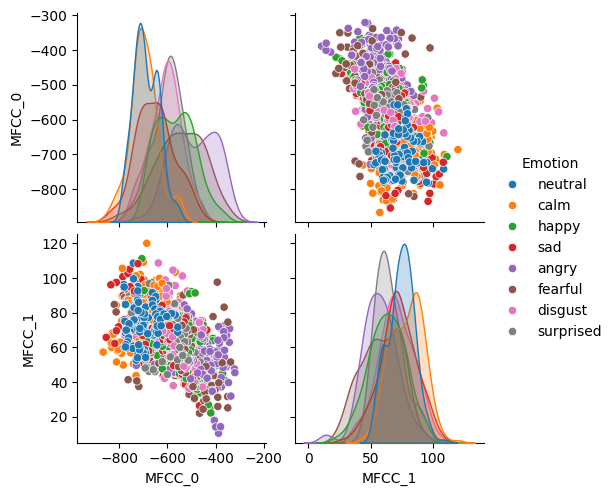

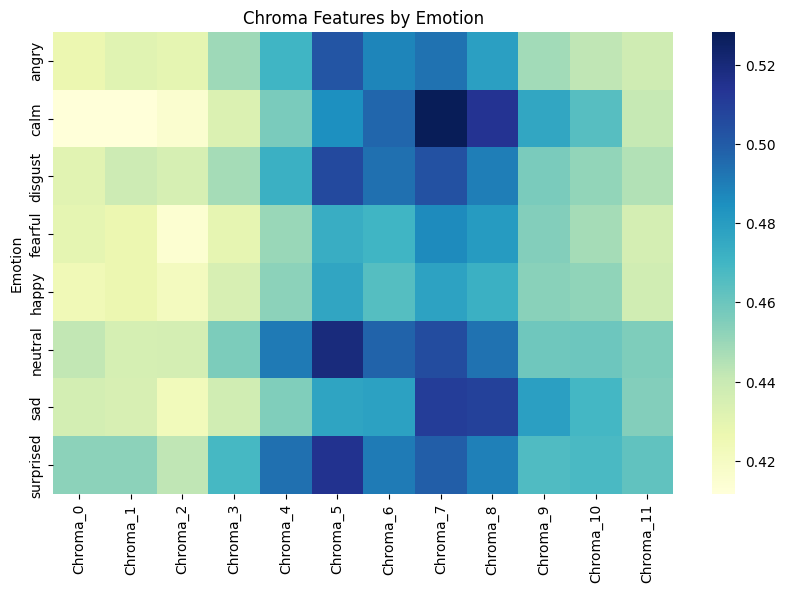

In [31]:
import seaborn as sns
import pandas as pd

# Create a DataFrame to store the features and labels for visualization
df = pd.DataFrame(features_balanced, columns=[f"MFCC_{i}" for i in range(13)] + 
                  [f"Chroma_{i}" for i in range(12)] + 
                  [f"Mel_{i}" for i in range(128)] + 
                  [f"Contrast_{i}" for i in range(7)] + 
                  [f"Tonnetz_{i}" for i in range(6)])
df['Emotion'] = labels_balanced

# Plot the first two MFCCs for each emotion
sns.pairplot(df, vars=["MFCC_0", "MFCC_1"], hue="Emotion")
plt.show()

# Plot the chroma features for each emotion
plt.figure(figsize=(10, 6))
sns.heatmap(df.groupby('Emotion')[
            [f"Chroma_{i}" for i in range(12)]
            ].mean(), cmap="YlGnBu")
plt.title("Chroma Features by Emotion")
plt.show()

### Encoding Labels and Standardizing Features 


In [12]:
# Encode the labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
print("Encoding labels are done")

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Completed Standardizing Features")

Encoding labels are done
Completed Standardizing Features


### Building the MLP Model

In [27]:
# Create an MLP classifier 
model_mlp = MLPClassifier(
    hidden_layer_sizes=(128,64,64,32), 
    max_iter=1000, random_state=42, 
    learning_rate='adaptive', 
    activation='relu', 
    solver='adam', 
    alpha=0.005,
    #verbose=True                     
)

# Train the model
model_mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = model_mlp.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred, normalize=True)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.67


### Fine-Tuning Hyperparameters 

In [28]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over, maintaining 3 hidden layers
param_grid = {
    'hidden_layer_sizes': [(128,64,64,32),(64,64,32,32)],  # Varying number of neurons in 3 layers
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1]  
}

# Create a GridSearchCV object
grid_search = GridSearchCV(model_mlp, param_grid, n_jobs=-1, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Get the best model from the grid search
best_mlp_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_mlp_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred, normalize=True)
print(f'Accuracy of the best model on the test set: {accuracy:.2f}')

Best Parameters:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64, 64, 32), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'solver': 'sgd'}
Best Score:  0.5993197278911564
Accuracy of the best model on the test set: 0.66


### Analysing Different Metrics 

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the original model
y_pred_original = model_mlp.predict(X_test)
print("Original Model Performance:")
print(classification_report(y_test, y_pred_original))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_original))

# Evaluate the best model from Grid Search
y_pred_best = best_mlp_model.predict(X_test)
print("\nBest Model Performance:")
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Original Model Performance:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        34
           1       0.79      0.69      0.74        45
           2       0.64      0.66      0.65        38
           3       0.71      0.71      0.71        38
           4       0.58      0.50      0.54        42
           5       0.80      0.84      0.82        43
           6       0.45      0.61      0.52        28
           7       0.67      0.65      0.66        40

    accuracy                           0.67       308
   macro avg       0.66      0.66      0.66       308
weighted avg       0.67      0.67      0.67       308

Confusion Matrix:
 [[22  0  6  1  1  1  0  3]
 [ 0 31  2  0  0  4  8  0]
 [ 2  1 25  2  4  1  1  2]
 [ 0  1  1 27  5  0  4  0]
 [ 7  0  3  3 21  0  5  3]
 [ 0  4  0  0  0 36  2  1]
 [ 0  2  0  1  1  3 17  4]
 [ 3  0  2  4  4  0  1 26]]

Best Model Performance:
              precision    recall  f1-score   support

     

### Implementing K-Fold Cross-Validation Techniques

In [30]:
from sklearn.model_selection import cross_val_score

# Evaluate the original model using 5-fold cross-validation
cv_scores_original = cross_val_score(model_mlp, X_train, y_train, cv=5, scoring='accuracy')
print(f"Original Model Cross-Validation Scores: {cv_scores_original}")
print(f"Original Model Average Cross-Validation Score: {np.mean(cv_scores_original):.2f}")

# Evaluate the best model using 5-fold cross-validation
cv_scores_best = cross_val_score(best_mlp_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nBest Model Cross-Validation Scores: {cv_scores_best}")
print(f"Best Model Average Cross-Validation Score: {np.mean(cv_scores_best):.2f}")

Original Model Cross-Validation Scores: [0.60162602 0.63821138 0.58536585 0.5877551  0.54285714]
Original Model Average Cross-Validation Score: 0.59

Best Model Cross-Validation Scores: [0.58943089 0.63821138 0.60569106 0.58367347 0.57959184]
Best Model Average Cross-Validation Score: 0.60


### Performing Comparative Study with Respect to SVM and KNN 

#### 1. Svm model

In [41]:
from sklearn.svm import SVC

# Create an SVM classifier
model_svm = SVC(kernel='rbf', C=100, gamma='auto')

# Train the model
model_svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = model_svm.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy of SVM Model: {accuracy_svm:.2f}')

Accuracy of SVM Model: 0.61


#### 2. Knn model

In [43]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN classifier
model_knn = KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')  

# Train the model
model_knn.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = model_knn.predict(X_test)

# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy of KNN Model: {accuracy_knn:.2f}')

Accuracy of KNN Model: 0.61


#### 3. Evaluate and Compare

In [46]:
# Evaluate SVM model
print("\nSVM Model Performance:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

# Evaluate KNN model
print("\nKNN Model Performance:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

# Perform cross-validation on SVM and KNN
cv_scores_svm = cross_val_score(model_svm, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nSVM Model Cross-Validation Scores: {cv_scores_svm}")
print(f"SVM Model Average Cross-Validation Score: {np.mean(cv_scores_svm):.2f}")

cv_scores_knn = cross_val_score(model_knn, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nKNN Model Cross-Validation Scores: {cv_scores_knn}")
print(f"KNN Model Average Cross-Validation Score: {np.mean(cv_scores_knn):.2f}")


SVM Model Performance:
              precision    recall  f1-score   support

           0       0.42      0.29      0.34        34
           1       0.78      0.87      0.82        45
           2       0.60      0.68      0.64        38
           3       0.43      0.63      0.51        38
           4       0.60      0.43      0.50        42
           5       0.79      0.86      0.82        43
           6       0.56      0.50      0.53        28
           7       0.64      0.53      0.58        40

    accuracy                           0.61       308
   macro avg       0.60      0.60      0.59       308
weighted avg       0.61      0.61      0.61       308

Confusion Matrix:
 [[10  1  5 16  1  0  0  1]
 [ 0 39  1  0  0  3  2  0]
 [ 2  0 26  3  4  0  0  3]
 [ 2  2  2 24  3  1  4  0]
 [ 6  1  3  5 18  3  2  4]
 [ 0  3  0  0  0 37  2  1]
 [ 0  4  0  3  2  2 14  3]
 [ 4  0  6  5  2  1  1 21]]

KNN Model Performance:
              precision    recall  f1-score   support

          